To Queue or Not to Queue
=====================

In this notebook we look at the relative performance of a single queue vs multiple queues
using the [Simpy](https://simpy.readthedocs.io/en/latest/) framework as well as exploring various
common load balancing algorithms and their performance in M/G/k systems.

First we establish a baseline simulator which can simulate arbitrary latency distributions and
generative processes.

In [27]:
# %load src/request_simulator.py
import random
from collections import namedtuple

import numpy as np
import simpy

LatencyDatum = namedtuple(
    'LatencyDatum',
    ('t_queued', 't_processing', 't_total')
)


class RequestSimulator(object):
    """ Simulates a M/G/k process common in request processing (computing)

    :param worker_desc: A tuple of (count, capacity) to construct workers with
    :param local_balancer: A function which takes the current request number
        and the list of workers and returns the index of the worker to send the
        next request to
    :param latency_fn: A function which takes the curent
        request number and the worker that was assigned by the load balancer
        amd returns the number of milliseconds a request took to process
    :param number_of_requests: The number of requests to run through the
        simulator
    :param request_per_s: The rate of requests per second.
    """

    def __init__(
            self, worker_desc, load_balancer, latency_fn,
            number_of_requests, request_per_s):
        self.worker_desc = worker_desc
        self.load_balancer = load_balancer
        self.latency_fn = latency_fn
        self.number_of_requests = int(number_of_requests)
        self.request_interval_ms = 1. / (request_per_s / 1000.)
        self.data = []

    def simulate(self):
        # Setup and start the simulation
        random.seed(1)
        np.random.seed(1)

        self.env = simpy.Environment()
        count, cap = self.worker_desc
        self.workers = []
        for i in range(count):
            worker = simpy.Resource(self.env, capacity=cap)
            worker.zone = "abc"[i % 3]
            self.workers.append(worker)
        self.env.process(self.generate_requests())
        self.env.run()

    def generate_requests(self):
        for i in range(self.number_of_requests):
            idx = self.load_balancer(i, self.workers)
            worker = self.workers[idx]
            response = self.process_request(
                i, worker,
            )
            self.env.process(response)
            # Exponential inter-arrival times == Poisson
            arrival_interval = random.expovariate(
                1.0 / self.request_interval_ms
            )
            yield self.env.timeout(arrival_interval)

    def process_request(self, request_id, worker):
        """ Request arrives, possibly queues, and then processes"""
        t_arrive = self.env.now

        with worker.request() as req:
            yield req
            t_start = self.env.now
            t_queued = t_start - t_arrive

            # Let the operation take w.e. amount of time the latency
            # function tells us to
            yield self.env.timeout(self.latency_fn(request_id, worker))

            t_done = self.env.now
            t_processing = t_done - t_start
            t_total_response = t_done - t_arrive

            datum = LatencyDatum(t_queued, t_processing, t_total_response)
            self.data.append(datum)


def run_simulation(
        worker_desc, load_balancer, num_requests, request_per_s, latency_fn):
    simulator = RequestSimulator(
        worker_desc, load_balancer, latency_fn,
        num_requests, request_per_s
    )
    simulator.simulate()
    return simulator.data


In [28]:
# %load src/lb_policies.py
import random

import numpy as np


def queue_size(resource):
    return resource.count + len(resource.queue)


def random_lb(request_num, workers):
    return random.randint(0, len(workers) - 1)


def rr_lb(request_num, workers):
    return request_num % len(workers)


def choice_two_lb(request_num, workers):
    r1, r2 = np.random.choice(range(len(workers)), 2, replace=False)
    r1 = random_lb(request_num, workers)
    r2 = random_lb(request_num, workers)
    if queue_size(workers[r1]) < queue_size(workers[r2]):
        return r1
    return r2


def _zone(request):
    return "abc"[request % 3]

def choice_n_weighted(n):
    def lb(request_num, workers):
        choices = np.random.choice(range(len(workers)), n, replace=False)
        result = []
        for idx, w in enumerate(choices):
            weight = 1.0;
            if _zone(request_num) == workers[w].zone:
                weight *= 1.0
            else:
                weight *= 4.0
            result.append((w, weight * (1 + queue_size(workers[w]))))

        result = sorted(result, key=lambda x:x[1])
        return result[0][0]
    return lb

def choice_two_adjacent_lb(request_num, workers):
    r1 = random_lb(request_num, workers)
    if r1 + 2 >= len(workers):
        r2 = r1 - 1
        r3 = r1 - 2
    else:
        r2 = r1 + 1
        r3 = r1 + 2

    iq = [(queue_size(workers[i]), i) for i in (r1, r2, r3)]
    return (sorted(iq)[0][1])


def shortest_queue_lb(request_num, workers):
    idx = 0
    for i in range(len(workers)):
        if queue_size(workers[i]) < queue_size(workers[idx]):
            idx = i
    return idx


In [29]:
# %load src/latency_distributions.py
import random

import numpy as np

def zone(request):
    return "abc"[request % 3]

def service(mean, slow, shape, slow_freq, slow_count):
    scale = mean - mean / shape
    scale_slow = slow - slow / shape

    def latency(request, worker):
        base = ((np.random.pareto(shape) + 1) * scale)
        if (zone(request) != worker.zone):
            base += 0.8
        if (request % slow_freq) < slow_count:
            add_l = ((np.random.pareto(shape) + 1) * scale_slow)
        else:
            add_l = 0
        return base + add_l
    return latency

def pareto(mean, shape):
    # mean = scale * shape / (shape - 1)
    # solve for scale given mean and shape (aka skew)
    scale = mean - mean / shape

    def latency(request, worker):
        return ((np.random.pareto(shape) + 1) * scale)
    return latency


def expon(mean):
    def latency(request, worker):
        return random.expovariate(1.0 / mean)
    return latency


Simulation of Single vs Multiple Queues
================================

Here we explore the effects of having N queues that handle 1/N the load (aka "Frequency Division Multiplexing",
aka `FDM`) vs a single queue distributing out to N servers (aka M/M/k queue aka `MMk`). We confirm the theoretical results that can be obtained using the closed form solutions for `E[T]_MMk` and `E[T]_FDM` via
a simulation.

In particular M/M/k queues have a closed form solution for the mean response time given the probability of queueing (and we know if requests queued)
```
E[T]_MMk = (1 / λ) * Pq * ρ / (1-ρ) + 1 / μ
Where
λ  = the arrival rate (hertz)
Pq = the probability of a request queueing
ρ  = the system load aka λ / (k * μ)
μ  = the average response time (hertz)
```

Frequency division multiplexing (multiple queues) also has a closed form solution:
```
E[T]_FDM = (k / (k * μ - λ))
```

In [30]:
# Simulate the various choices
NUM_REQUESTS = 60000
QPS = 18000
AVG_RESPONSE_MS = 0.4
SERVERS = 10

In [31]:
multiple_queues_latency = []
for i in range(SERVERS):
    multiple_queues_latency.extend([
        i[2] for i in run_simulation((1, 1), rr_lb, NUM_REQUESTS/SERVERS, QPS/SERVERS, expon(AVG_RESPONSE_MS))
    ])
    
single_queue = [
    i for i in run_simulation((1, SERVERS), rr_lb, NUM_REQUESTS, QPS, expon(AVG_RESPONSE_MS))
]
single_queue_latency = [i[2] for i in single_queue]

Pq = sum([i[0] > 0 for i in single_queue]) / float(NUM_REQUESTS)

# MMk have a closed for mean given the probability of queueing (and we know if requests queued)
# E[T]_MMk = (1 / λ) * Pq * ρ / (1-ρ) + 1 / μ
# Where
# λ  = the arrival rate (hertz)
# Pq = the probability of a request queueing
# ρ  = the system load aka λ / (k * μ)
# μ  = the average response time (hertz)
mu_MMk = (1.0 / AVG_RESPONSE_MS) * 1000
lambda_MMk = QPS
rho_MMk = lambda_MMk / (SERVERS * mu_MMk)
expected_MMk_mean_s = (1 / (lambda_MMk)) * Pq * (rho_MMk / (1-rho_MMk)) + 1 / mu_MMk
expected_MMk_mean_ms = expected_MMk_mean_s * 1000.0

# Frequency-division multiplexing also has a closed form for mean
# E[T]_FDM = (k / (k * μ - λ))

expected_FDM_mean_ms = (SERVERS / (SERVERS * mu_MMk - lambda_MMk)) * 1000.0

print("Theory Results")
print("--------------")
print("Pq       = {0:4.2f}".format(Pq))
print("E[T]_FDM = {0:4.2f}".format(expected_FDM_mean_ms))
print("E[T]_MMk = {0:4.2f}".format(expected_MMk_mean_ms))

# And now the simulation
queueing_options = {
    'Multiple Queues': multiple_queues_latency,
    'Single Queue': single_queue_latency,
}

print()
print("Simulation results")
print("------------------")
hdr = "{0:16} | {1:>7} | {2:>7} | {3:>7} | {4:>7} | {5:>7} | {6:>7} |".format(
"Strategy", "mean", "var", "p50", "p95", "p99", "p99.9")
print(hdr)
for opt in sorted(queueing_options.keys()):
    mean = np.mean(queueing_options[opt])
    var = np.var(queueing_options[opt])
    percentiles = np.percentile(queueing_options[opt], [50, 95, 99, 99.9])
    print ("{0:16} | {1:7.2f} | {2:7.2f} | {3:7.2f} | {4:7.2f} | {5:>7.2f} | {6:7.2f} |".format(
        opt, mean, var, percentiles[0], percentiles[1], percentiles[2],
        percentiles[3]
    ))

Theory Results
--------------
Pq       = 0.25
E[T]_FDM = 1.43
E[T]_MMk = 0.44

Simulation results
------------------
Strategy         |    mean |     var |     p50 |     p95 |     p99 |   p99.9 |
Multiple Queues  |    1.34 |    1.63 |    0.97 |    3.92 |    5.96 |    7.91 |
Single Queue     |    0.44 |    0.17 |    0.31 |    1.24 |    1.89 |    2.79 |


/tmp/ipykernel_12596/2226680928.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-pastel')


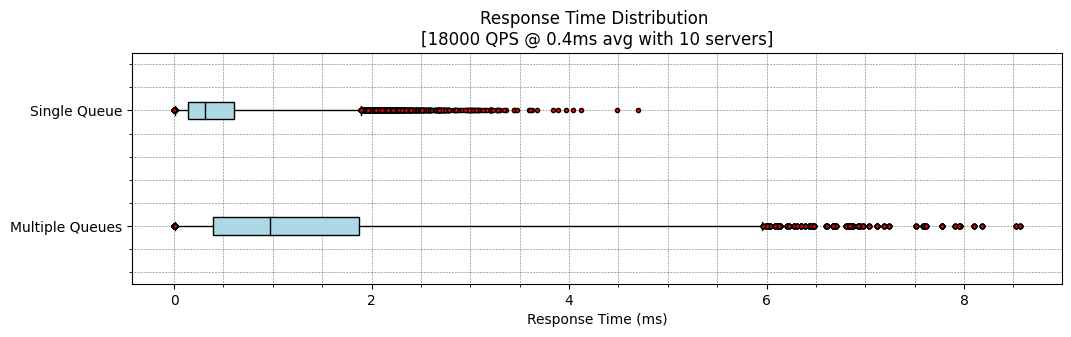

In [32]:
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.style as style

style.use('seaborn-pastel')

def color_bplot(bp, edge_color, fill_color):
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for box in bp['boxes']:
        box.set_facecolor(fill_color)  

fig1, ax = plt.subplots(figsize=(12,3))

opts = sorted(queueing_options.keys())
data = [queueing_options[i] for i in opts]

flier = dict(markerfacecolor='r', marker='.')
bplot1 = ax.boxplot(data,whis=[1,99],showfliers=True,flierprops=flier, labels=opts,
                    patch_artist=True, vert=False)
color_bplot(bplot1, 'black', 'lightblue')

plt.title("Response Time Distribution \n[{0} QPS @ {1}ms avg with {2} servers]".format(
    QPS, AVG_RESPONSE_MS, SERVERS)
)

plt.minorticks_on()
plt.grid(which='major', linestyle=':', linewidth='0.4', color='black')
# Customize the minor grid
plt.grid(which='minor', linestyle=':', linewidth='0.4', color='black')
plt.xlabel('Response Time (ms)')
plt.show()

In [33]:
from multiprocessing import Pool

def run_multiple_simulations(simulation_args):
    with Pool(12) as p:
        results = p.starmap(run_simulation, simulation_args)
    return results

In [34]:
# Should overload 10 servers with 0.4ms avg response time at 25k
qps_range = [i*1000 for i in range(1, 21)]
multi = []
num_requests = 100000

# Can't pickle inner functions apparently...
def expon_avg(request, worker):
    return random.expovariate(1.0 / AVG_RESPONSE_MS)

print("Multi Queues")
args = []
for qps in qps_range:
    args.clear()
    multiple_queues_latency = []
    for i in range(SERVERS):
        args.append(
            ((1, 1), rr_lb, num_requests/SERVERS, qps/SERVERS, expon_avg)
        )
    for d in run_multiple_simulations(args):
        multiple_queues_latency.extend([i.t_total for i in d])
    print('({0:>4.2f} -> {1:>4.2f})'.format(qps, np.mean(multiple_queues_latency)), end=', '),
    percentiles = np.percentile(multiple_queues_latency, [10, 50, 90])
    multi.append(percentiles)

single = []
args.clear()
for qps in qps_range:
    args.append(
        ((1, SERVERS), rr_lb, num_requests, qps, expon_avg)
    )
    
print("\nSingle Queue")
for idx, results in enumerate(run_multiple_simulations(args)):
    d = [i.t_total for i in results]
    print('({0:>4.2f} -> {1:>4.2f})'.format(qps_range[idx], np.mean(d)), end=', ')

    percentiles = np.percentile(d, [25, 50, 75])

    single.append(percentiles)

Multi Queues
(1000.00 -> 0.41), (2000.00 -> 0.43), (3000.00 -> 0.45), (4000.00 -> 0.47), (5000.00 -> 0.49), (6000.00 -> 0.52), (7000.00 -> 0.55), (8000.00 -> 0.57), (9000.00 -> 0.61), (10000.00 -> 0.64), (11000.00 -> 0.71), (12000.00 -> 0.78), (13000.00 -> 0.85), (14000.00 -> 0.97), (15000.00 -> 0.96), (16000.00 -> 1.11), (17000.00 -> 1.29), (18000.00 -> 1.42), (19000.00 -> 1.75), (20000.00 -> 1.85), 
Single Queue
(1000.00 -> 0.40), (2000.00 -> 0.40), (3000.00 -> 0.40), (4000.00 -> 0.40), (5000.00 -> 0.40), (6000.00 -> 0.40), (7000.00 -> 0.40), (8000.00 -> 0.40), (9000.00 -> 0.40), (10000.00 -> 0.40), (11000.00 -> 0.40), (12000.00 -> 0.40), (13000.00 -> 0.40), (14000.00 -> 0.41), (15000.00 -> 0.41), (16000.00 -> 0.42), (17000.00 -> 0.42), (18000.00 -> 0.44), (19000.00 -> 0.45), (20000.00 -> 0.48), 

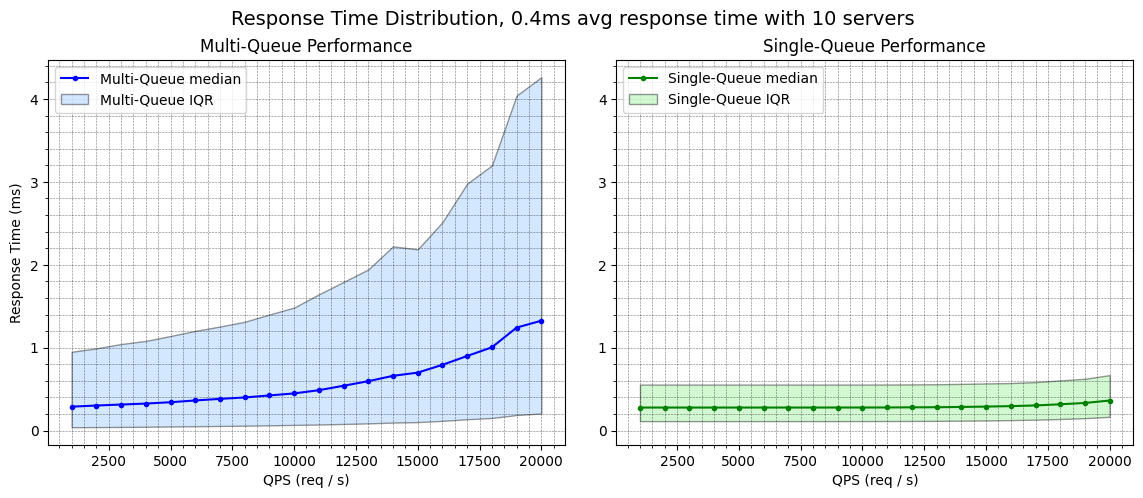

In [35]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 2, hspace=0.1, wspace=0.1)

plt.suptitle("Response Time Distribution, {0}ms avg response time with {1} servers".format(
    AVG_RESPONSE_MS, SERVERS), fontsize=14
)

ax1 = plt.subplot(gs[0, 0])

ax1.plot(qps_range, [m[1] for m in multi], '.b-', label='Multi-Queue median')
ax1.fill_between(qps_range, [m[0] for m in multi], [m[2] for m in multi], alpha=0.4,
                label='Multi-Queue IQR', edgecolor='black')

ax1.set_title('Multi-Queue Performance')
ax1.minorticks_on()
ax1.grid(which='major', linestyle=':', linewidth='0.4', color='black')
ax1.grid(which='minor', linestyle=':', linewidth='0.4', color='black')
ax1.set_xlabel('QPS (req / s)')
ax1.set_ylabel('Response Time (ms)')
ax1.legend(loc='upper left')

ax2 = plt.subplot(gs[0, 1], sharey=ax1)
ax2.plot(qps_range, [m[1] for m in single], '.g-', label='Single-Queue median')
ax2.fill_between(qps_range, [m[0] for m in single], [m[2] for m in single], alpha=0.4,
                label='Single-Queue IQR', color='lightgreen', edgecolor='black')

ax2.set_title('Single-Queue Performance')
ax2.minorticks_on()
ax2.grid(which='major', linestyle=':', linewidth='0.4', color='black')
ax2.grid(which='minor', linestyle=':', linewidth='0.4', color='black')
ax2.set_xlabel('QPS (req / s)')
ax2.legend(loc='upper left')

plt.show()

Multiple Queues: Load Balancing
===========================

Now we look at the affects of choosing different load balancing algorithms on the multiple queue approach:

1. Random Load Balancer: This strategy chooses a server at random
2. Join Shortest Queue: This strategy chooses the shortest queue to ensure load balancing
3. Two adjacent: Somewhat of a variant of "choice of two" where you randomly pick two servers
   and take the shortest queue between them; modified to only allow neighbors
   
   

In [36]:
multiple_queues_latency = []
for i in range(SERVERS):
    multiple_queues_latency.extend([
        i[2] for i in run_simulation((1, 1), rr_lb, NUM_REQUESTS/SERVERS,
                                     request_per_s=QPS/SERVERS, latency_fn=expon(AVG_RESPONSE_MS))
    ])

random_queue_latency = [
    i[2] for i in run_simulation((SERVERS, 1), random_lb, NUM_REQUESTS, QPS, expon(AVG_RESPONSE_MS))
]

join_shorted_queue_latency = [
    i[2] for i in run_simulation((SERVERS, 1), shortest_queue_lb, NUM_REQUESTS, QPS, expon(AVG_RESPONSE_MS))
]

two_adjacent_latency = [
    i[2] for i in run_simulation((SERVERS, 1), choice_two_adjacent_lb, NUM_REQUESTS, QPS, expon(AVG_RESPONSE_MS))
]


# And now the simulation
all_queueing_options = {
    'Multiple Queues': multiple_queues_latency,
    'Single Queue': single_queue_latency,
    'LB: Join Shortest': join_shorted_queue_latency,
    'LB: Best of Two Adj': two_adjacent_latency,
    'LB: Random': random_queue_latency
}

print()
print("Simulation results")
print("------------------")
hdr = "{0:20} | {1:>7} | {2:>7} | {3:>7} | {4:>7} | {5:>7} | {6:>7} ".format(
"Strategy", "mean", "var", "p50", "p95", "p99", "p99.9")
print(hdr)
for opt in sorted(all_queueing_options.keys()):
    mean = np.mean(all_queueing_options[opt])
    var = np.var(all_queueing_options[opt])
    percentiles = np.percentile(all_queueing_options[opt], [50, 95, 99, 99.9])
    print ("{0:20} | {1:7.2f} | {2:7.2f} | {3:7.2f} | {4:7.2f} | {5:>7.2f} | {6:7.2f} |".format(
        opt, mean, var, percentiles[0], percentiles[1], percentiles[2],
        percentiles[3]
    ))


Simulation results
------------------
Strategy             |    mean |     var |     p50 |     p95 |     p99 |   p99.9 
LB: Best of Two Adj  |    0.71 |    0.42 |    0.53 |    2.01 |    2.95 |    4.25 |
LB: Join Shortest    |    0.48 |    0.22 |    0.34 |    1.42 |    2.16 |    3.16 |
LB: Random           |    1.37 |    1.86 |    0.95 |    4.06 |    6.44 |    9.22 |
Multiple Queues      |    1.34 |    1.63 |    0.97 |    3.92 |    5.96 |    7.91 |
Single Queue         |    0.44 |    0.17 |    0.31 |    1.24 |    1.89 |    2.79 |


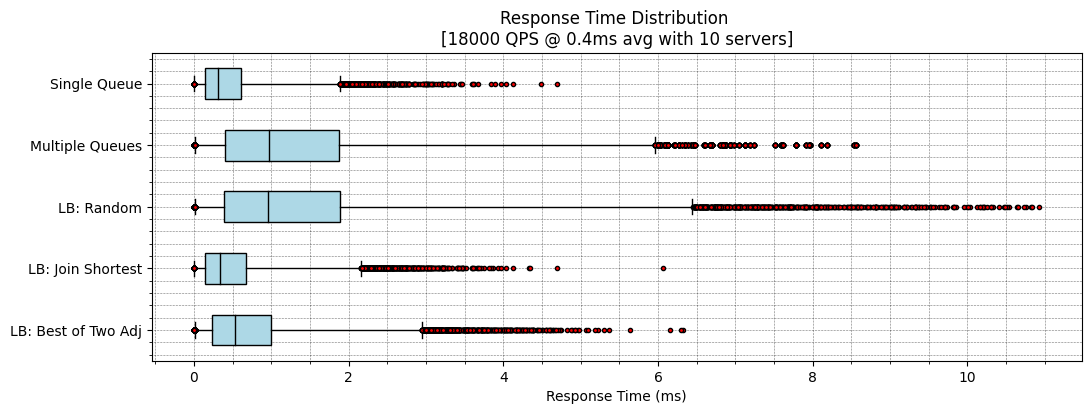

In [37]:
fig1, ax = plt.subplots(figsize=(12,4))

opts = sorted(all_queueing_options.keys())
data = [all_queueing_options[i] for i in opts]

bplot1 = ax.boxplot(data, whis=[1,99],showfliers=True,flierprops=flier, labels=opts,
                    patch_artist=True, vert=False)
color_bplot(bplot1, 'black', 'lightblue')

plt.title("Response Time Distribution \n[{0} QPS @ {1}ms avg with {2} servers]".format(
    QPS, AVG_RESPONSE_MS, SERVERS)
)

plt.minorticks_on()
plt.grid(which='major', linestyle=':', linewidth='0.4', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.4', color='black')
plt.xlabel('Response Time (ms)')
plt.show()

Simulation of M/G/k queues
======================

Now we look at M/G/k queues over multiple different load balancing choices.

We explore:
* Join Shorted Queue (JSK): The request is dispatched to the shortest queue
* M/G/k (MGk): A single queue is maintained and workers take requests as they are free
* Choice of two (choice_two): Two random workers are chosen, and then the request goes to the shorter queue
* Random (random): A random queue is chosen
* Round-robin (roundrobin): The requests are dispatched to one queue after the other


In [38]:
lb_algos = {
    'choice-of-two': choice_two_lb,
    'random': random_lb,
    'round-robin': rr_lb,
    'shortest-queue': shortest_queue_lb,
    'weighted-choice-8': choice_n_weighted(8),
}

SERVERS = 16
QPS = 8000
# Every 1000 requests have 10 that are slow (simulating a GC pause)
latency = service(AVG_RESPONSE_MS, 20, 2, 1000, 10)

lbs = {
    k : [i[2] for i in run_simulation((SERVERS, 1), v, NUM_REQUESTS, QPS, latency)]
    for (k, v) in lb_algos.items()
}
lbs['MGk'] = [
    i[2] for i in run_simulation((1, SERVERS), rr_lb, NUM_REQUESTS, QPS, latency)]

#lbs['join-idle'] = [
#    i[2] for i in run_simulation((1, SERVERS), rr_lb, NUM_REQUESTS, QPS,
#                                 lambda request: 0.1 + pareto(AVG_RESPONSE_MS, 2)(request))
#]

types = sorted(lbs.keys())

hdr = "{0:20} | {1:>7} | {2:>7} | {3:>7} | {4:>7} | {5:>7} | {6:>7} ".format(
"Strategy", "mean", "var", "p50", "p95", "p99", "p99.9")
print(hdr)
print("-"*len(hdr))
for lb in types:
    mean = np.mean(lbs[lb])
    var = np.var(lbs[lb])
    percentiles = np.percentile(lbs[lb], [50, 95, 99, 99.9])
    print ("{0:20} | {1:7.1f} | {2:7.1f} | {3:7.1f} | {4:7.1f} | {5:>7.1f} | {6:7.1f} |".format(
        lb, mean, var, percentiles[0], percentiles[1], percentiles[2],
        percentiles[3]
    ))

Strategy             |    mean |     var |     p50 |     p95 |     p99 |   p99.9 
---------------------------------------------------------------------------------
MGk                  |     1.3 |     7.2 |     1.0 |     2.7 |    11.0 |    33.4 |
choice-of-two        |     2.5 |   107.9 |     1.1 |     7.6 |    30.2 |   121.6 |
random               |     6.2 |   205.1 |     1.4 |    32.0 |    77.1 |   126.2 |
round-robin          |     4.0 |   111.2 |     1.1 |    18.9 |    57.3 |   111.5 |
shortest-queue       |     1.5 |    14.9 |     1.0 |     2.4 |    15.5 |    50.7 |
weighted-choice-8    |     0.9 |    15.0 |     0.3 |     1.6 |    17.2 |    57.1 |


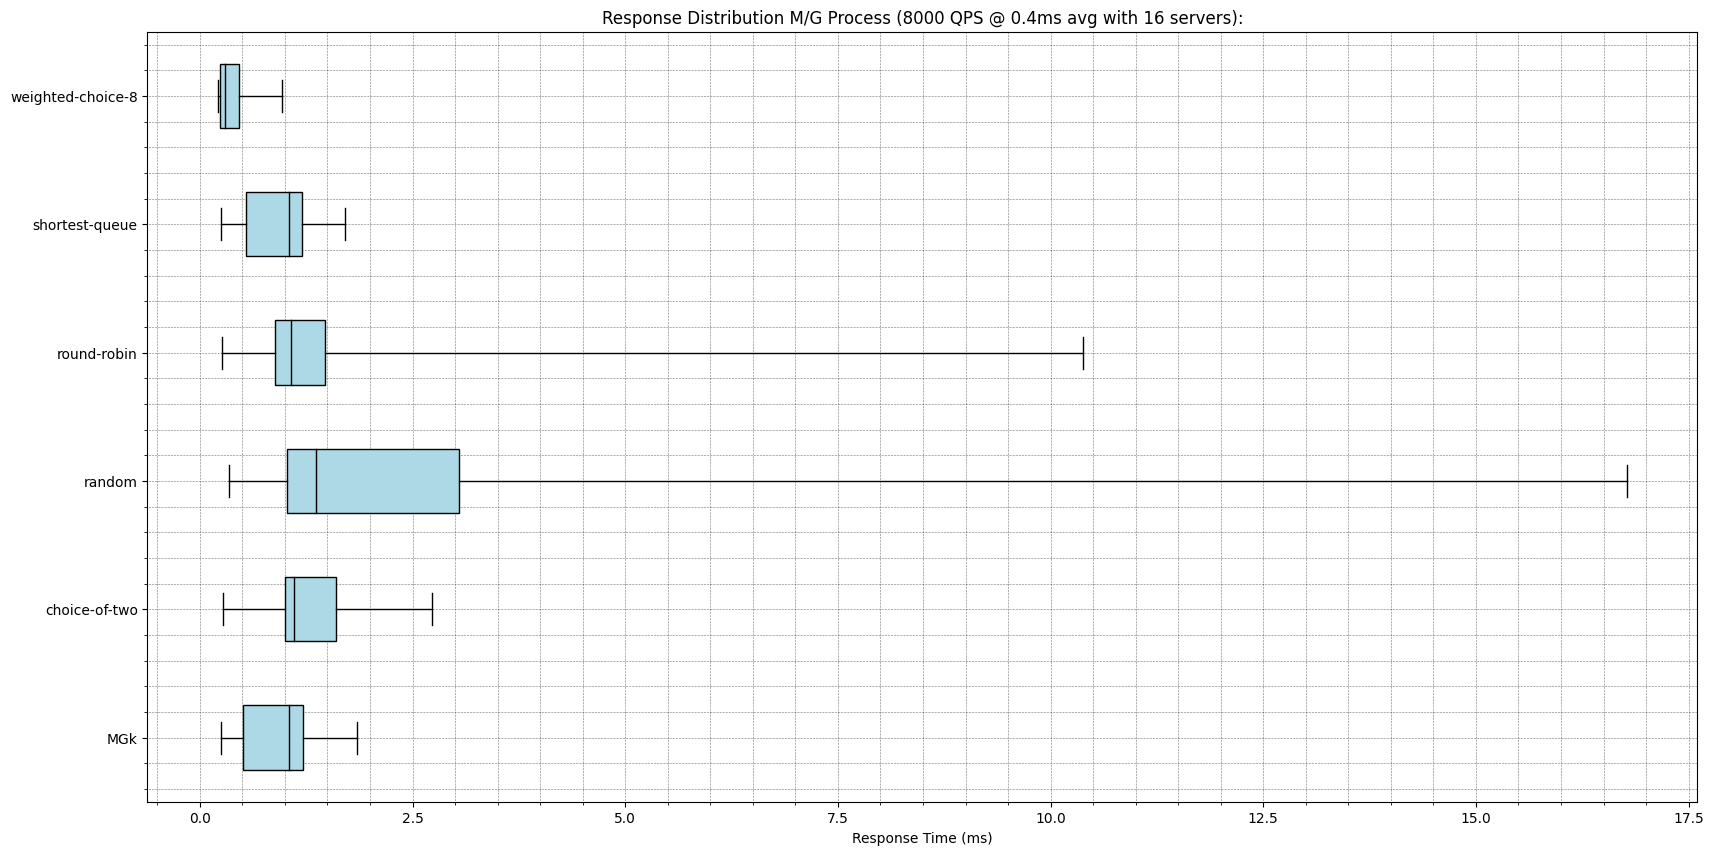

In [39]:
fig1, ax = plt.subplots(figsize=(20,10))

diamond = dict(markerfacecolor='r', marker='D')

data = [lbs[i] for i in types]
bplot1 = ax.boxplot(data, whis=[10,90],showfliers=False,flierprops=flier, labels=types,
                    patch_artist=True, vert=False)
color_bplot(bplot1, 'black', 'lightblue')

plt.title('Response Distribution M/G Process ({0} QPS @ {1}ms avg with {2} servers):'.format(
    QPS, AVG_RESPONSE_MS, SERVERS)
)
plt.minorticks_on()
plt.grid(which='major', linestyle=':', linewidth='0.4', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.4', color='black')
plt.xlabel('Response Time (ms)')
plt.show()